<a href="https://colab.research.google.com/github/Neha1025/Stock-Price-Prediction/blob/main/Apple_stock_price_prediction_using_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from itertools import cycle
import plotly.express as px
from plotly.subplots import make_subplots
import os
import datetime as dt


from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU


In [ ]:
# Importing dataset

#data = pd.read_csv("/Users/neha/Downloads/AAPL.csv")
#df = pd.DataFrame(data)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AAPL.csv to AAPL (2).csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['AAPL.csv']))

In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1.254000e+03
mean,67.888786,68.617373,67.174354,67.928622,66.759659,1.230865e+08
std,36.691447,37.123432,36.194865,36.670378,37.154673,5.620835e+07
min,26.642500,26.920000,26.020000,26.427500,24.912027,4.544800e+07
25%,41.349376,41.867499,40.879374,41.313125,39.788848,8.600860e+07
50%,50.851252,51.309999,50.539999,50.953750,49.844178,1.081781e+08
75%,90.996876,91.753748,89.570623,91.027496,90.282982,1.430536e+08
max,156.979996,157.259995,154.389999,156.690002,156.690002,4.479400e+08


In [ ]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-10-03,28.177500,28.262501,28.070000,28.129999,26.381451,86807200
1,2016-10-04,28.264999,28.577499,28.157499,28.250000,26.493996,118947200
2,2016-10-05,28.350000,28.415001,28.172501,28.262501,26.505718,85812400
3,2016-10-06,28.424999,28.584999,28.282499,28.472500,26.702663,115117200
4,2016-10-07,28.577499,28.639999,28.377501,28.514999,26.742521,97433600


In [ ]:
# showing column wise %ge of NaN values they contains 

for i in df.columns:
  print(i,"\t-\t", df[i].isna().mean()*100)

Date 	-	 0.0
Open 	-	 0.0
High 	-	 0.0
Low 	-	 0.0
Close 	-	 0.0
Adj Close 	-	 0.0
Volume 	-	 0.0


In [ ]:
#df = df[df['symbol']=='AAPL']   # Choosin stock values for any company 

#cormap = df.corr()
#fig, ax = plt.subplots(figsize=(5,5))
#sns.heatmap(cormap, annot = True)

In [ ]:
df = df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})

In [ ]:
df.head()

,date,open,high,low,close,adj_close,volume
0,2016-10-03,28.177500,28.262501,28.070000,28.129999,26.381451,86807200
1,2016-10-04,28.264999,28.577499,28.157499,28.250000,26.493996,118947200
2,2016-10-05,28.350000,28.415001,28.172501,28.262501,26.505718,85812400
3,2016-10-06,28.424999,28.584999,28.282499,28.472500,26.702663,115117200
4,2016-10-07,28.577499,28.639999,28.377501,28.514999,26.742521,97433600


In [ ]:
print("Total number of days: ",df.shape[0])
print("Total number of fields: ",df.shape[1])

Total number of days:  1254
Total number of fields:  7


In [ ]:
# convert date field from string to Date format 
df['date'] = pd.to_datetime(df.date)
df.head()

,date,open,high,low,close,adj_close,volume
0,2016-10-03,28.177500,28.262501,28.070000,28.129999,26.381451,86807200
1,2016-10-04,28.264999,28.577499,28.157499,28.250000,26.493996,118947200
2,2016-10-05,28.350000,28.415001,28.172501,28.262501,26.505718,85812400
3,2016-10-06,28.424999,28.584999,28.282499,28.472500,26.702663,115117200
4,2016-10-07,28.577499,28.639999,28.377501,28.514999,26.742521,97433600


In [ ]:
print("Starting date: ",df.iloc[0][0])
print("Ending date: ", df.iloc[-1][0])
print("Duration: ", df.iloc[-1][0]-df.iloc[0][0])

Starting date:  2016-10-03 00:00:00
Ending date:  2021-09-24 00:00:00
Duration:  1817 days 00:00:00


In [ ]:
#Monthwise comparision between Stock open and close price
monthwise= df.groupby(df['date'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)
monthwise

,open,close
date,,
January,63.510711,63.588333
February,65.515369,65.523894
March,63.017455,63.031205
April,66.136796,66.224757
May,65.927948,65.993561
June,70.215281,70.366402
July,75.490213,75.657642
August,80.844820,81.005270
September,81.722732,81.374407


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
#Monthwise high and low stock price
df.groupby(df['date'].dt.strftime('%B'))['low'].min()
monthwise_high = df.groupby(df['date'].dt.strftime('%B'))['high'].max()
monthwise_high = monthwise_high.reindex(new_order, axis=0)

monthwise_low = df.groupby(df['date'].dt.strftime('%B'))['low'].min()
monthwise_low = monthwise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthwise_high.index,
    y=monthwise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthwise_low.index,
    y=monthwise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()


In [ ]:
import plotly
plotly.__version__ 

'5.3.1'

In [ ]:
#!pip install plotly
#!pip install plotly --upgrade

In [ ]:
#Trend comparision between stock open price, close price, high price, low price
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(df, x=df.date, y=[df['open'], df['close'], 
                                          df['high'], df['low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [ ]:
#Make separate dataframe of close price as we are going to predict the closing price for next 30 days
closedf = df[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1254, 2)


In [ ]:
#Plotting Stock Close price chart
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
closedf = closedf[closedf['date'] > '2020-09-24']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  252


In [ ]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
#Normalizing close price
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(252, 1)


In [ ]:
#prepare data for training and testing
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (151, 1)
test_data:  (101, 1)


Transform Close price base on Time-series-analysis forecasting requirement

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (135, 15)
y_train:  (135,)
X_test:  (85, 15)
y_test (85,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (135, 15, 1)
X_test:  (85, 15, 1)


In [ ]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 15, 32)            3360      
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 32)            6336      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
5/5 [==============================] - 6s 276ms/step - loss: 0.0681 - val_loss: 0.0598
Epoch 2/200
5/5 [==============================] - 0s 30ms/step - loss: 0.0195 - val_loss: 0.0055
Epoch 3/200
5/5 [==============================] - 0s 32ms/step - loss: 0.0201 - val_loss: 0.0214
Epoch 4/200
5/5 [==============================] - 0s 30ms/step - loss: 0.0122 - val_loss: 0.0577
Epoch 5/200
5/5 [==============================] - 0s 32ms/step - loss: 0.0143 - val_loss: 0.0449
Epoch 6/200
5/5 [==============================] - 0s 31ms/step - loss: 0.0120 - val_loss: 0.0195
Epoch 7/200
5/5 [==============================] - 0s 30ms/step - loss: 0.0107 - val_loss: 0.0121
Epoch 8/200
5/5 [==============================] - 0s 31ms/step - loss: 0.0096 - val_loss: 0.0138
Epoch 9/200
5/5 [==============================] - 0s 29ms/step - loss: 0.0110 - val_loss: 0.0213
Epoch 10/200
5/5 [==============================] - 0s 31ms/step - loss: 0.0090 - val_loss: 0.0134
Epoch 11/200
5/5 [

Plot the loss chart

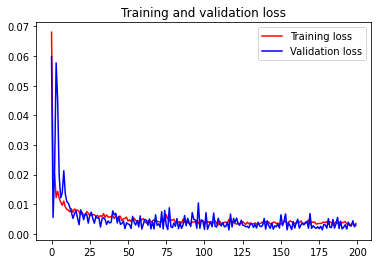

<Figure size 432x288 with 0 Axes>

In [ ]:

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((135, 1), (85, 1))

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
import math
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  2.3978698444827606
Train data MSE:  5.74977979107978
Train data MAE:  1.8568620416738997
-------------------------------------------------------------------------------------
Test data RMSE:  2.6029019350325258
Test data MSE:  6.775098483396066
Test data MAE:  2.0748404954848345


In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.8999835302358671
Test data explained variance regression score: 0.9581069927313809


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.8999445181282838
Test data R2 score: 0.9190485027602817


In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.00037385379456815585
Test data MGD:  0.0003253576006547612
----------------------------------------------------------------------
Train data MPD:  0.04628078289517753
Test data MPD:  0.046907257880382545


Comparision of original stock close price and predicted close price

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (252, 1)
Test predicted data:  (252, 1)


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()